# **Projekt z zakresu analizy danych**



**Autorzy**: 
 - Patrycja Mazur (nr albumu: 100992) 
 - Weronika Poniedziałek (nr albumu: 101002)

## **Cel projektu**:

Celem analizy jest stworzenie i wdrożenie modeli predykcyjnych do przewidywania rodzaju kawy na podstawie danych zawartych w zbiorze. Analiza obejmuje identyfikację kluczowych cech wpływających na decyzje klientów oraz opracowanie modeli, oraz klasyfikacja: Przewidywanie typu kawy na podstawie cech takich jak wielkość opakowania, typ palenia, czy cena za jednostkę.

Zdecydowałyśmy się na przewidywanie typu kawy, ponieważ taki projekt jest pomocny w optymalizacji oferty kawowej oraz zwiększeniu zysków poprzez lepsze dopasowanie produktów do potrzeb klientów, a również opracowaniu skutecznych strategii marketingowych.

## **Opis zbioru danych**:

Analizowałyśmy zbiór danych o nazwie CoffeeOrdersData, który pochodzi z Kaggle. 
 - https://www.kaggle.com/datasets/rashid7274/data-analysis-on-coffee-sales-data

Nasz zbiór danych podzielony jest na trzy główne arkusze, które reprezentują różne aspekty operacji związanych z kawą:
 1. *Orders Data* - zawiera szczegóły dotyczące zamówień (np. ID produktu, datę zamówienia, wielkość opakowania, wartość sprzedaży)
 2. *Costumer Data* - zawiera dane o klientach (np. Imię, miasto, status posiadania karty lojalnościowej)
 3. *Product Data* - zawiera dane o produktach (np. typ kawy, typ palenia, rozmiar kawy, marża z zysku)


## **Struktura projektu**:

Projekt jest podzielony na następujące sekcje w następujący sposób:
 1. Opis zbioru danych. 

 2. Przygotowanie danych: Oczyszczenie, transformacje i analiza wstępna.
 3. Statystyki opisowe oraz wizualizacje i odkrycie zależności.
 4. Modelowanie predykcyjne: Porównanie modeli klasyfikacyjnych (Gradient Boosting, Decision Tree, Random Forest).
 5. Redukcja wymiarowości: Wykorzystanie metod PCA i ICA do zidentyfikowania kluczowych cech.
 6. Wyniki i wnioski: Podsumowanie analiz oraz porównanie modeli.

In [430]:
# analiza i wizualizacja
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#przetwarzanie danych
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# modelowanie
from sklearn.model_selection import train_test_split
from pycaret.anomaly import *  
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import accuracy_score, classification_report


# Wczytanie danych

In [431]:
plik = "CoffeeOrdersData.xlsx"

dane = pd.read_excel(plik)
wszystkie_arkusze = pd.read_excel(plik, sheet_name=['Orders', 'Customers', 'Products'])

arkusz1 = wszystkie_arkusze["Orders"]
arkusz2 = wszystkie_arkusze["Customers"]
arkusz3 = wszystkie_arkusze["Products"]

Dane składają się z 3 ramek danych: "Orders", "Customers" oraz "Products".

### **Arkusz "Orders" (Zamówienia)**

Zawiera 1000 rekordów opisujących zamówienia.
Kolumny obejmują informacje takie jak:
 - *Order ID*: Identyfikator zamówienia.
 - *Order Date*: Data zamówienia.
 - *Customer ID*: Identyfikator klienta.
 - *Product ID*: Identyfikator produktu.
 - *Quantity*, *Size*, *Unit Price*, *Sales*: Szczegóły dotyczące ilości, rozmiaru, ceny jednostkowej i sprzedaży.

In [432]:
arkusz1.head()

,Order ID,Order Date,Customer ID,Product ID,Quantity,Size,Unit Price,Sales
0,QEV-37451-860,2019-09-05,17670-51384-MA,R-M-1,2,1.0,9.950,19.90
1,QEV-37451-860,2019-09-05,17670-51384-MA,E-M-0.5,5,0.5,8.250,41.25
2,FAA-43335-268,2021-06-17,21125-22134-PX,A-L-1,1,1.0,12.950,12.95
3,KAC-83089-793,2021-07-15,23806-46781-OU,E-M-1,2,1.0,13.750,27.50
4,KAC-83089-793,2021-07-15,23806-46781-OU,R-L-2.5,2,2.5,27.485,54.97


In [433]:
print(arkusz1.isna().sum())

Order ID       0
Order Date     0
Customer ID    0
Product ID     0
Quantity       0
Size           0
Unit Price     0
Sales          0
dtype: int64


Nie występują braki danych.

In [434]:
print(arkusz1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order ID     1000 non-null   object        
 1   Order Date   1000 non-null   datetime64[ns]
 2   Customer ID  1000 non-null   object        
 3   Product ID   1000 non-null   object        
 4   Quantity     1000 non-null   int64         
 5   Size         1000 non-null   float64       
 6   Unit Price   1000 non-null   float64       
 7   Sales        1000 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 62.6+ KB
None


Dane są zróżnicowane pod względem typu danych, występuje data (datetime64[ns]), wartości numeryczne (float64, int64), a także dane tekstowe (object).

### **Arkusz "Customers" (Klienci)**

Zawiera dane o 1000 klientach.
Kolumny obejmują:
 - *Customer ID*: Identyfikator klienta.
 - *Customer Name*, *Email*, *Phone Number*: Dane kontaktowe klientów.
 - *Address Line 1*, *City*, *Country*, *Postcode*: Szczegóły adresowe.
 - *Loyalty Card*: Status posiadania karty lojalnościowej.

In [435]:
arkusz2.head()

,Customer ID,Customer Name,Email,Phone Number,Address Line 1,City,Country,Postcode,Loyalty Card
0,17670-51384-MA,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,Yes
1,73342-18763-UW,Piotr Bote,pbote1@yelp.com,+353 (913) 396-4653,2112 Ridgeway Hill,Crumlin,Ireland,D6W,No
2,21125-22134-PX,Jami Redholes,jredholes2@tmall.com,+1 (210) 986-6806,5214 Bartillon Park,San Antonio,United States,78205,Yes
3,71253-00052-RN,Dene Azema,dazema3@facebook.com,+1 (217) 418-0714,27 Maywood Place,Springfield,United States,62711,Yes
4,23806-46781-OU,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,No


In [436]:
print(arkusz2.isna().sum())

Customer ID         0
Customer Name       0
Email             204
Phone Number      130
Address Line 1      0
City                0
Country             0
Postcode            0
Loyalty Card        0
dtype: int64


Zauważamy, że w kolumnach 'Email' oraz 'Phone Number' występują braki danych.

In [437]:
print(arkusz2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer ID     1000 non-null   object
 1   Customer Name   1000 non-null   object
 2   Email           796 non-null    object
 3   Phone Number    870 non-null    object
 4   Address Line 1  1000 non-null   object
 5   City            1000 non-null   object
 6   Country         1000 non-null   object
 7   Postcode        1000 non-null   object
 8   Loyalty Card    1000 non-null   object
dtypes: object(9)
memory usage: 70.4+ KB
None


Wszytskie dane są teskstowe (object).

### **Arkusz "Products" (Produkty)**

Zawiera informacje o 48 produktach.
Kolumny obejmują:
 - *Product ID*: Identyfikator produktu.
 - *Coffee Type*, *Roast Type*: Typ kawy i rodzaj palenia.
 - *Size*, *Unit Price*, *Price per 100g*, *Profit*: Szczegóły dotyczące rozmiaru, ceny jednostkowej, ceny za 100 g i zysku.

In [438]:
arkusz3.head()

,Product ID,Coffee Type,Roast Type,Size,Unit Price,Price per 100g,Profit
0,A-L-0.2,Ara,L,0.2,3.885,1.9425,0.34965
1,A-L-0.5,Ara,L,0.5,7.770,1.5540,0.69930
2,A-L-1,Ara,L,1.0,12.950,1.2950,1.16550
3,A-L-2.5,Ara,L,2.5,29.785,1.1914,2.68065
4,A-M-0.2,Ara,M,0.2,3.375,1.6875,0.30375


In [439]:
print(arkusz3.isna().sum())

Product ID        0
Coffee Type       0
Roast Type        0
Size              0
Unit Price        0
Price per 100g    0
Profit            0
dtype: int64


Nie występują braki danych.

In [440]:
print(arkusz3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product ID      48 non-null     object 
 1   Coffee Type     48 non-null     object 
 2   Roast Type      48 non-null     object 
 3   Size            48 non-null     float64
 4   Unit Price      48 non-null     float64
 5   Price per 100g  48 non-null     float64
 6   Profit          48 non-null     float64
dtypes: float64(4), object(3)
memory usage: 2.8+ KB
None


#### Rodzaje kawy:

In [441]:
arkusz3["Coffee Type"].value_counts()

Coffee Type
Ara    12
Rob    12
Lib    12
Exc    12
Name: count, dtype: int64

Mamy 4 rodzaje kawy: Robusta, Excelsa, Liberica, Arabica

#### Palenie kawy

In [442]:
arkusz3["Roast Type"].value_counts()

Roast Type
L    16
M    16
D    16
Name: count, dtype: int64

Rodzaje palenia:
 - M - Średnie palenie
 - D - Ciemne palenie
 - L - Jasne palenie

#### Rozmiary kaw

In [443]:
arkusz3["Size"].value_counts()

Size
0.2    12
0.5    12
1.0    12
2.5    12
Name: count, dtype: int64

Mamy 4 wielkości rozmiarów kaw: 0.2kg, 0.5kg, 1kg, 2.5kg. 

Każdy z 4 rodzajów kawy (Robusta, Excelsa, Liberica, Arabica) ma 3 stopnie wypalenia kawy (M, D, L), a każdy stopień wypalenia kawy danego rodzaju można zakupić w 4 różnych wielkościach: (0.2, 0.5, 1.0, 2.5)

# **Statystyki opisowe**

Zgrupujemy dane aby oobliczyć sumę dla każdego zamówienia oraz ilość zamówionych produktów.

In [444]:
order_totals = arkusz1.groupby('Order ID')['Sales'].sum().reset_index()

order_totals = arkusz1.groupby('Order ID').agg(
    Sales=('Sales', 'sum'),
    Quantity=('Quantity', 'sum')
).reset_index()

order_totals.head()

,Order ID,Sales,Quantity
0,AAQ-13644-699,35.800,4
1,ABK-08091-531,47.550,3
2,ABO-29054-365,40.500,6
3,ACY-56225-839,77.625,3
4,ADP-04506-084,189.750,6


## **Statystyki opisowe dla sprzedaży**

In [445]:
print(order_totals['Sales'].describe())
order_totals['Sales'].sum()

count    957.000000
mean      47.162231
std       44.457677
min        2.685000
25%       16.500000
50%       29.850000
75%       61.755000
max      281.675000
Name: Sales, dtype: float64


45134.255000000005

Średnia wartość zysku wynosi około 47.16, z odchyleniem standardowym 44.46, co wskazuje na dużą zmienność w sprzedaży.
Najmniejsza wartość sprzedaży wynosi 2.69, a największa 281.68.
Prawie wszystkie wartości mieszczą się w przedziale od 16.50 do 61.76, z wyjątkiem pojedynczych dużych wartości sprzedaży.

##### Wykres rozrzutu dla zysku z zamówień 

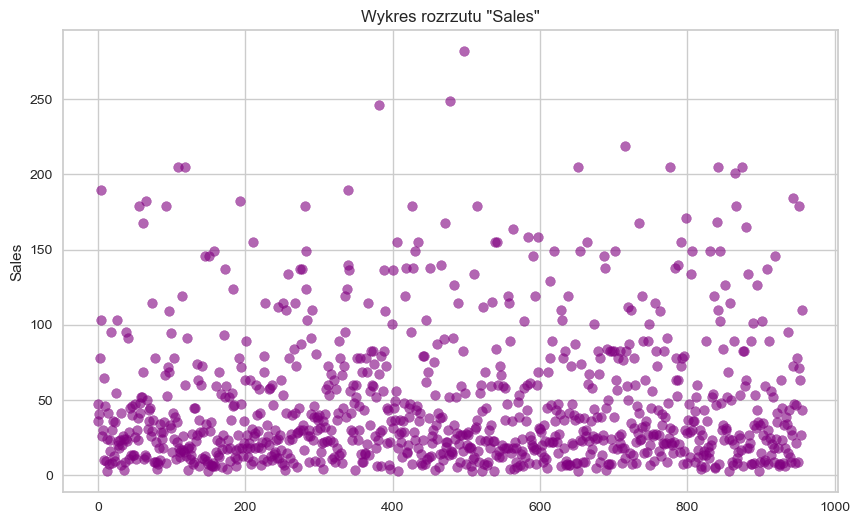

In [446]:
plt.figure(figsize=(10,6))
plt.scatter(order_totals.index, order_totals['Sales'], alpha=0.6, color='purple')
plt.title('Wykres rozrzutu "Sales"')
plt.ylabel('Sales')
plt.show()

Zyski mają zróżnicowaną wartość.

##### Histogram dla zysku z zamówień

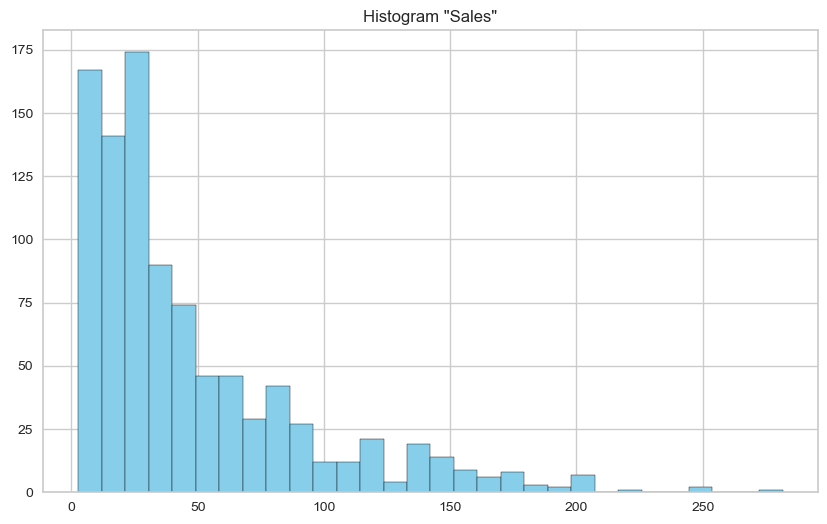

In [447]:
plt.figure(figsize=(10, 6))
plt.hist(order_totals['Sales'], bins=30, edgecolor='black', color='skyblue')
plt.title('Histogram "Sales"')
plt.show()

Histogram przedstawia rozkład zysków, gdzie największa częstość występuje w przedziale od 0 do 50, co sugeruje, że zamówienia są głównie o niskich kwotach.

##### Wykres pudełkowy

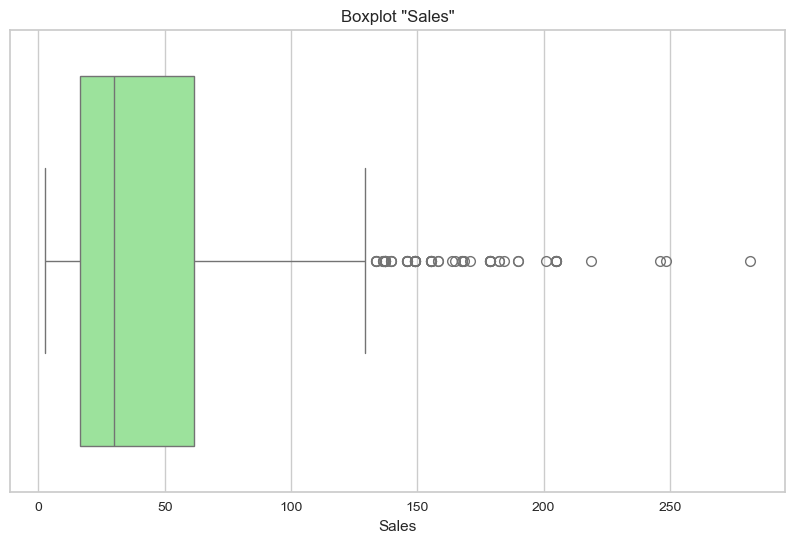

In [448]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=order_totals['Sales'], color='lightgreen')
plt.title('Boxplot "Sales"')
plt.xlabel('Sales')
plt.show()


Boxplot potwierdza wczesniejsze wnioski, zauważamy, że pojawiają się pojedyncze zamówienia o znacznie wyższych zyskach.

## **Ilość zamówionych produktów w jednym zamówieniu**

In [449]:
order_totals['Quantity'].describe()

count    957.000000
mean       3.710554
std        1.996551
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       18.000000
Name: Quantity, dtype: float64

Średnia ilość zamówionych produktów wynosi około 3,71, co oznacza, że najczęściej zamawiane są niewielkie ilości. Większość zamówień mieści się w przedziale od 2 do 5 produktów.

##### Wykres rozrzutu

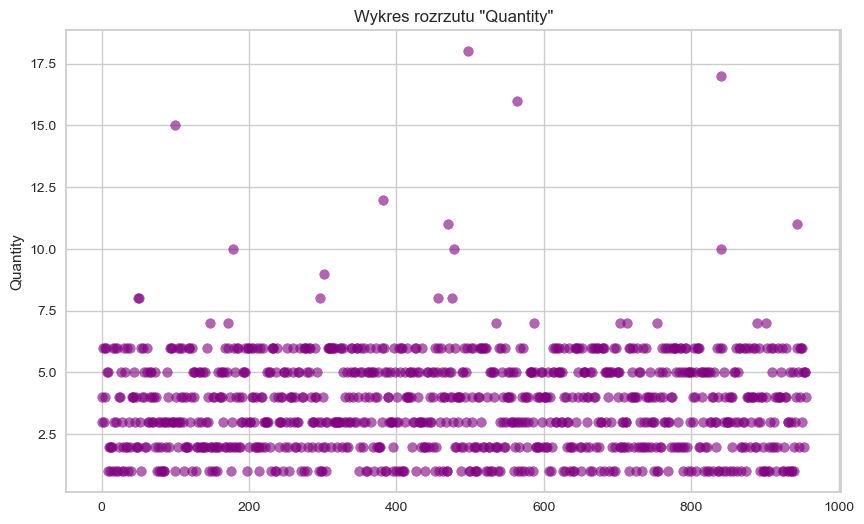

In [450]:
plt.figure(figsize=(10, 6))
plt.scatter(order_totals.index, order_totals['Quantity'], alpha=0.6, color='purple')
plt.title('Wykres rozrzutu "Quantity"')
plt.ylabel('Quantity')
plt.show()

Z wykresu rozrzutu możemy wywnioskować, że zdecydowana większość zamówień składa się od 1 do 6 produktów.

##### Histogram

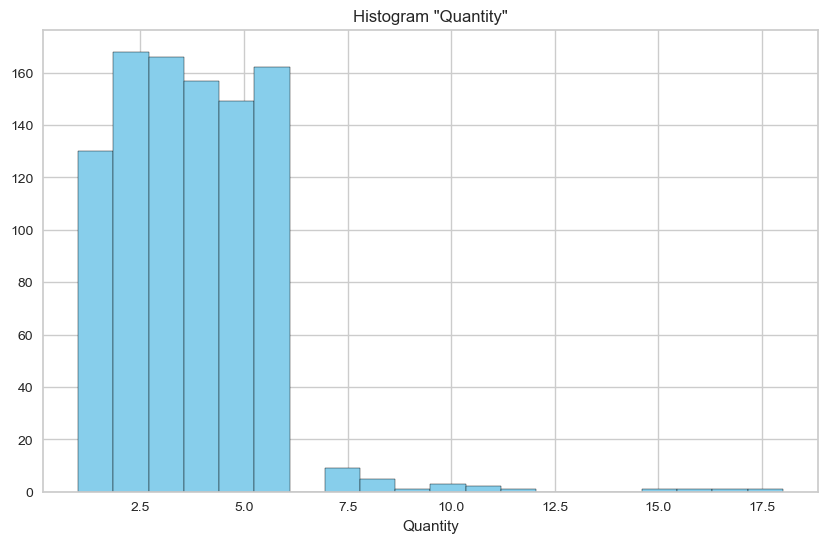

In [451]:
plt.figure(figsize=(10, 6))
plt.hist(order_totals['Quantity'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram "Quantity"')
plt.xlabel('Quantity')
plt.show()

Histogram potwierdza tezę, że najczęściej jest zamawianych od 1 do 6 prodoktów na zamówienie.

##### Wykres pudełkowy

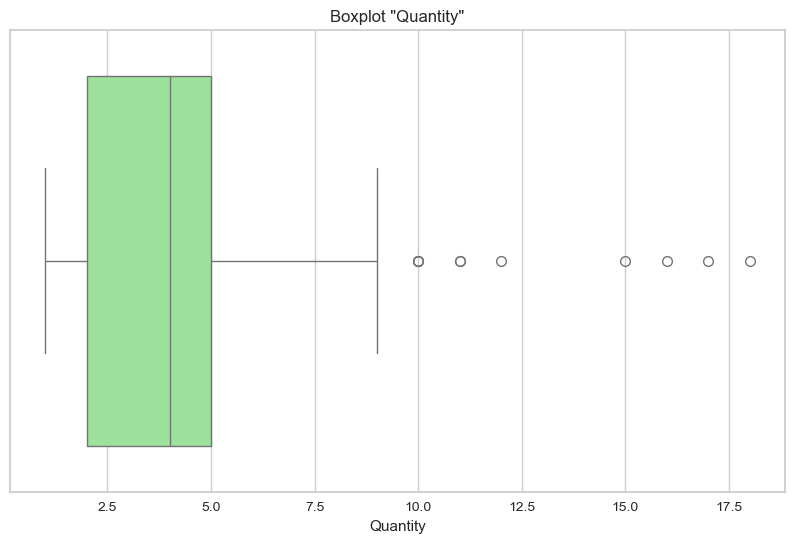

In [452]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=order_totals['Quantity'], color='lightgreen')
plt.title('Boxplot "Quantity"')
plt.xlabel('Quantity')
plt.show()

Z wykresu udełkowego ponownie możemy wyciągnąć podobne wnioski, zauważamy, że rzadko zdarza się żeby zamówienie składało się z większej ilości produktów.

## **Statystyki dla zysku z zamówień**

In [453]:
print(arkusz3['Profit'].describe())
arkusz3['Profit'].sum()

count    48.000000
mean      1.316219
std       1.161426
min       0.161100
25%       0.501300
50%       0.943800
75%       1.657700
max       4.739150
Name: Profit, dtype: float64


63.17849999999999

Analiza zysku z zamówień pokazuje, że średni zysk wynosi około 1.32, przy rozpiętości od 0.16 do 4.74. Połowa zamówień generuje zysk poniżej 0.94 (mediana), a trzy czwarte zamówień poniżej 1.66. Łączny zysk ze wszystkich zamówień wynosi 63.18.

##### Wykres rozrzutu

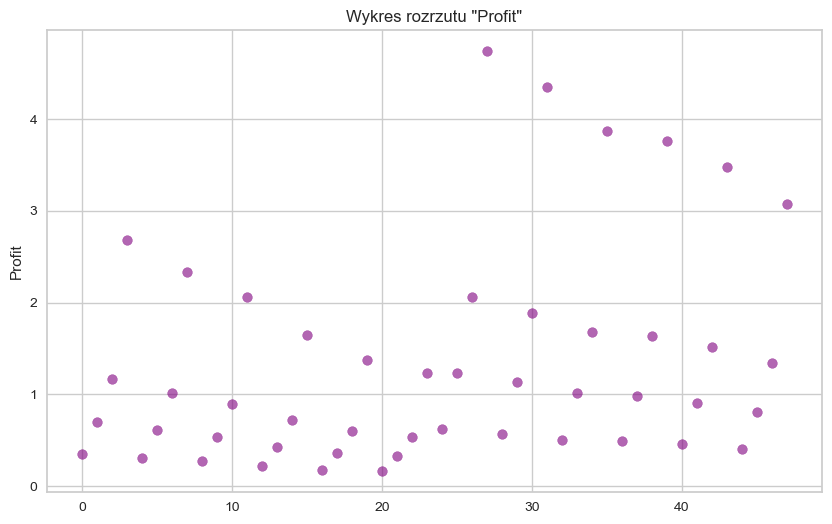

In [454]:
plt.figure(figsize=(10, 6))
plt.scatter(arkusz3.index, arkusz3['Profit'], alpha=0.6, color='purple')
plt.title('Wykres rozrzutu "Profit"')
plt.ylabel('Profit')
plt.show()

Na wykresie rozrzutu można zauważyć charakterystyczny układ punktów, które grupują się w pewne wzorce, najczęściej po cztery. Może to sugerować różnice w cenach i zyskach w zależności od rodzaju kawy. Niektóre rodzaje kaw generują wyższe marże zysku, co może być wynikiem wyższych cen lub innych czynników, takich jak popularność produktu czy koszty produkcji.

##### Wykres pudełkowy

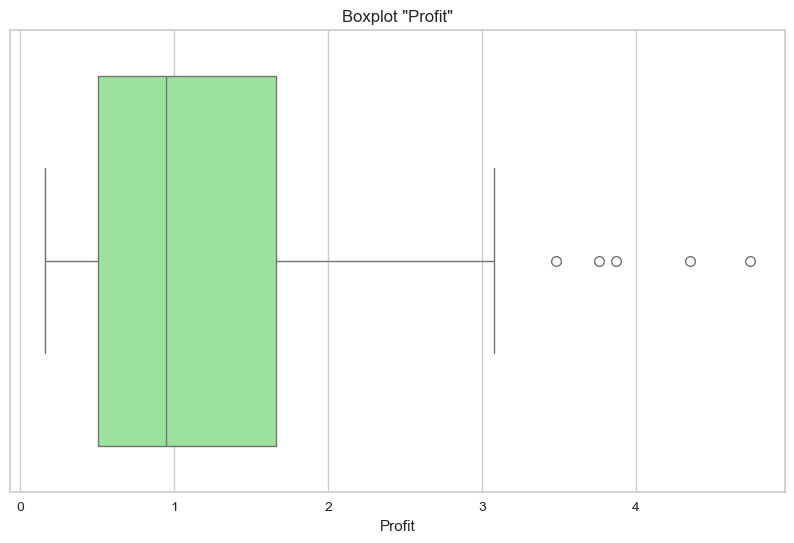

In [455]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=arkusz3['Profit'], color='lightgreen')
plt.title('Boxplot "Profit"')
plt.xlabel('Profit')
plt.show()

Większość wartości profitu mieści się w przedziale od 0.5 do 1.7, co wskazuje na stosunkowo wąski zakres zysków dla większości zamówień. Wyższe wartości są rzadziej spotykane, co może świadczyć o specyficznych produktach lub zamówieniach generujących większe marże.

##### Histogram

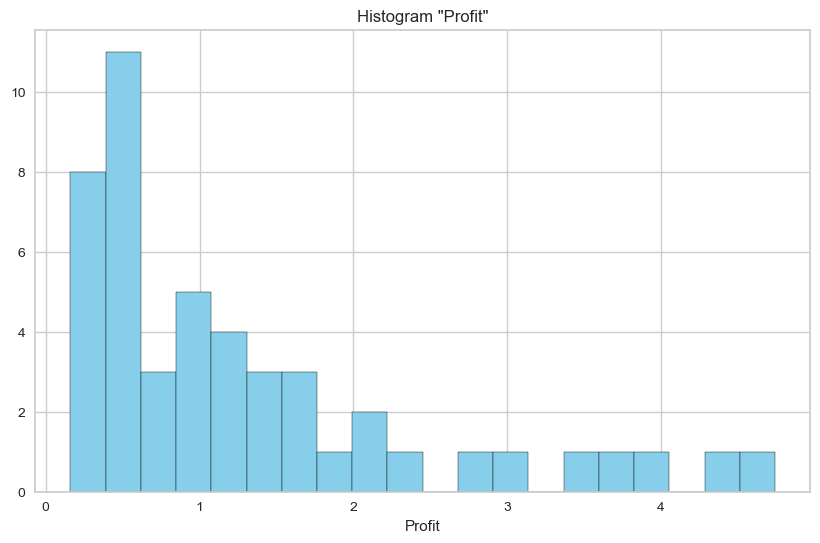

In [456]:
plt.figure(figsize=(10, 6))
plt.hist(arkusz3['Profit'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram "Profit"')
plt.xlabel('Profit')
plt.show()

Histogram potwierdza wcześniejszy przypuszczenia.

## **Statystyki opisowe dla Unit Price**

In [457]:
print(arkusz3['Unit Price'].describe())

count    48.000000
mean     13.046250
std       9.953578
min       2.685000
25%       5.216250
50%       9.230000
75%      17.033750
max      36.455000
Name: Unit Price, dtype: float64


Ceny jednostkowe w danych wahają się od 2.69 do 36.46, z medianą na poziomie 9.23. Większość cen mieści się w przedziale od 5.22 (25. percentyl) do 17.03 (75. percentyl). Średnia cena jednostkowa wynosi 13.05.

##### Wykres rozrzutu

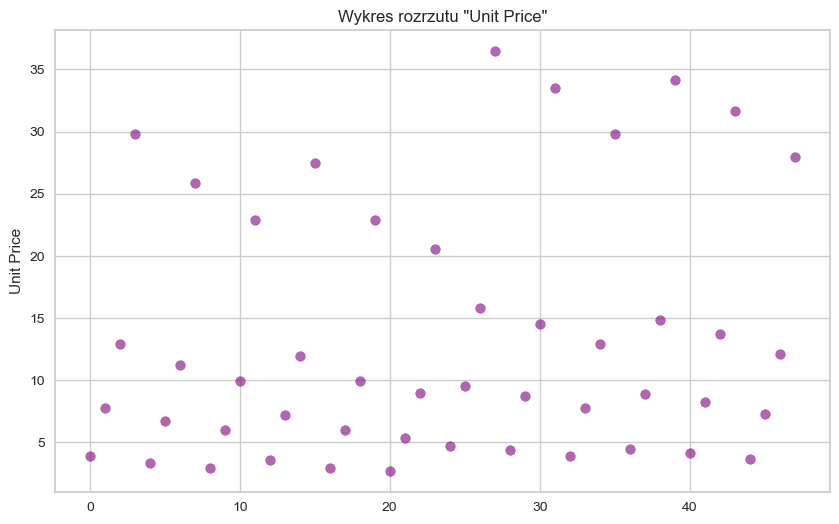

In [458]:
plt.figure(figsize=(10, 6))
plt.scatter(arkusz3.index, arkusz3['Unit Price'], alpha=0.6, color='purple')
plt.title('Wykres rozrzutu "Unit Price"')
plt.ylabel('Unit Price')
plt.show()

Wykres rozrzutu prezentuje charakterystyczny układ punktów, które grupują się w zauważalne wzorce, najczęściej po cztery. Sugeruje to, że powtarzające się wartości co cztery mogą być związane z kawami o większej wadze.

##### Wykres pudełkowy

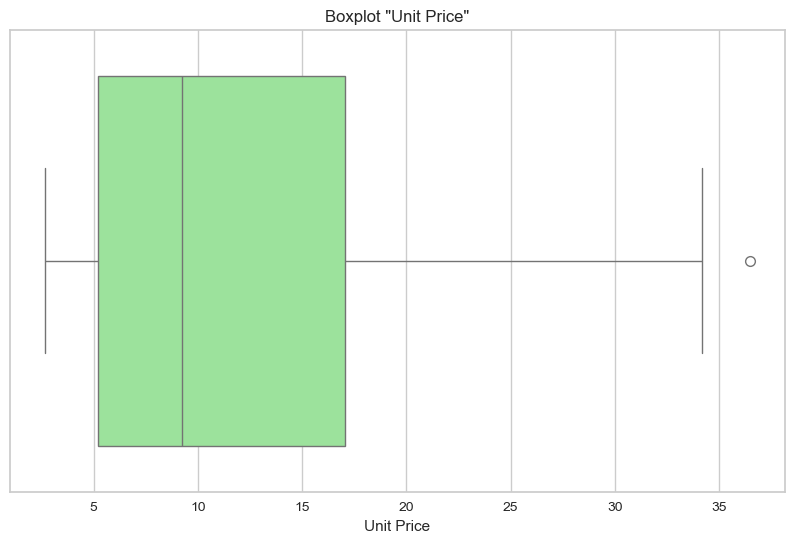

In [459]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=arkusz3['Unit Price'], color='lightgreen')
plt.title('Boxplot "Unit Price"')
plt.xlabel('Unit Price')
plt.show()

Większość wartości jest skoncentrowana wokół mediany, a jedynie jedna wartość odstaje wyraźnie od reszty.

##### Histogram

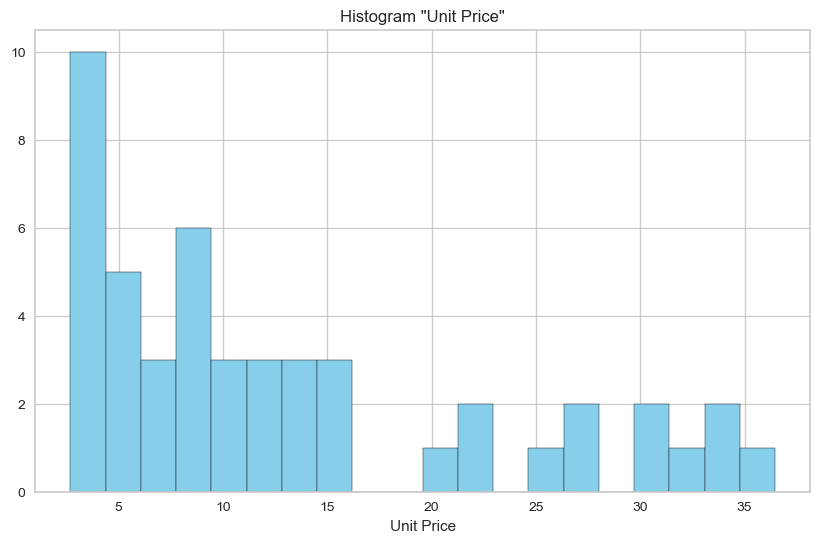

In [460]:
plt.figure(figsize=(10, 6))
plt.hist(arkusz3['Unit Price'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram "Unit Price"')
plt.xlabel('Unit Price')
plt.show()

Histogram pokazuje, że większość zysku koncentruje się w przedziale do 16, z mniejszą liczbą wartości w wyższych przedziałach.

## **Zmienna Coffee Type**

In [461]:
orders_customers = arkusz1.merge(arkusz2, on='Customer ID', how='left')
merged_data = orders_customers.merge(arkusz3, on='Product ID', how='left')
merged_data.head()

merged_data["Coffee Type"].value_counts()

Coffee Type
Ara    264
Lib    248
Exc    247
Rob    241
Name: count, dtype: int64

w całym zbiorze danych najwięcej zamówień dotyczy kawy typu Ara (264 zamówienia), zaraz za nim znajdują się Lib (248 zamówień), Exc (247 zamówień), a najmniejszą liczbę zamówień odnotowano dla Rob (241 zamówień). Zamówienia są stosunkowo dobrze rozłożone wśród tych czterech głównych kategorii.

##### Wykres słupkowy

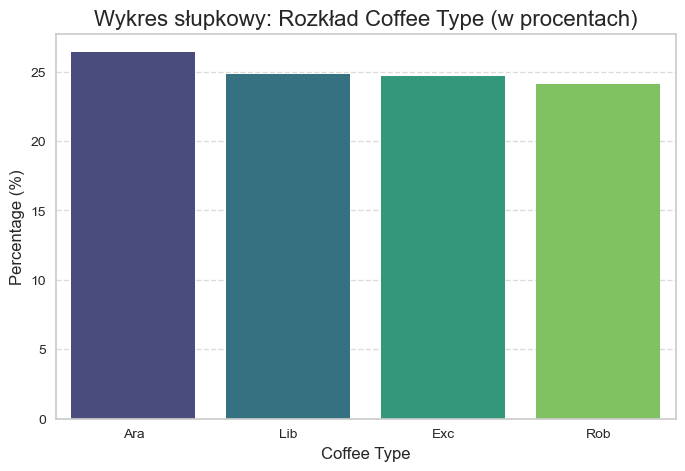

In [462]:
# Statystyki dla Coffee Type
statystyki_coffee_type = merged_data['Coffee Type'].value_counts().reset_index()
statystyki_coffee_type.columns = ['Coffee Type', 'Frequency']
statystyki_coffee_type['Percentage'] = (statystyki_coffee_type['Frequency'] / statystyki_coffee_type['Frequency'].sum()) * 100
 
# Procentowy udział każdej kategorii
statystyki_coffee_type['Percentage'] = (statystyki_coffee_type['Frequency'] / 
                                        statystyki_coffee_type['Frequency'].sum()) * 100


plt.figure(figsize=(8, 5))
sns.barplot(data=statystyki_coffee_type, x='Coffee Type', y='Percentage', palette='viridis')
plt.title("Wykres słupkowy: Rozkład Coffee Type (w procentach)", fontsize=16)
plt.xlabel("Coffee Type", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Wykres rorzutu

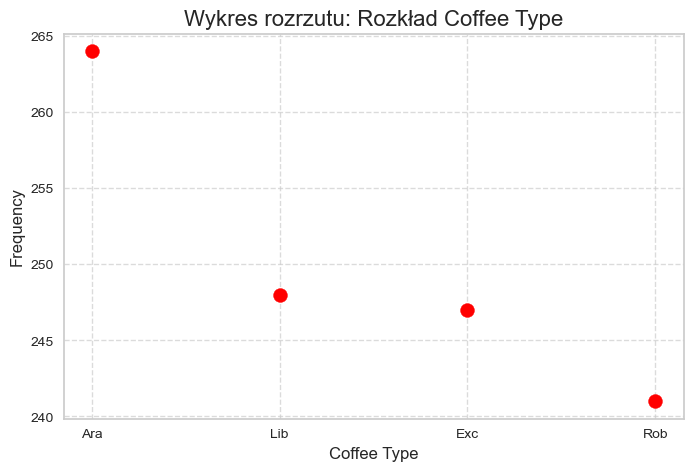

In [463]:
plt.figure(figsize=(8, 5))
plt.scatter(statystyki_coffee_type['Coffee Type'], statystyki_coffee_type['Frequency'], color='red', s=100)
plt.title("Wykres rozrzutu: Rozkład Coffee Type", fontsize=16)
plt.xlabel("Coffee Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()
 


# Połączenie danych

In [464]:
orders_customers = arkusz1.merge(arkusz2, on='Customer ID', how='left')
merged_data = orders_customers.merge(arkusz3, on='Product ID', how='left')
merged_data.head()

# Usunięcie kolumn Size_y i Unit Price_y, ponieważ to te same co Size_x i Unit Price_x
merged_data = merged_data.drop(columns=[ "Size_y", "Unit Price_y"])

# Zamiana nazwy Size_x i Unit Price_x na Size i Unit Price
merged_data = merged_data.rename(columns={
    'Size_x': 'Size',
    'Unit Price_x': 'Unit Price'
})

# Zamiana 'Yes' na 1 i 'No' na 0 w kolumnie 'Loyalty Card'
merged_data['Loyalty Card'] = merged_data['Loyalty Card'].map({'Yes': 1, 'No': 0})

# Przeniesienie kolumny "Coffee Type" na koniec
columns = [col for col in merged_data.columns if col != "Coffee Type"] + ["Coffee Type"]
merged_data = merged_data[columns]


merged_data.head()


,Order ID,Order Date,Customer ID,Product ID,Quantity,Size,Unit Price,Sales,Customer Name,Email,Phone Number,Address Line 1,City,Country,Postcode,Loyalty Card,Roast Type,Price per 100g,Profit,Coffee Type
0,QEV-37451-860,2019-09-05,17670-51384-MA,R-M-1,2,1.0,9.950,19.90,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,1,M,0.9950,0.5970,Rob
1,QEV-37451-860,2019-09-05,17670-51384-MA,E-M-0.5,5,0.5,8.250,41.25,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,1,M,1.6500,0.9075,Exc
2,FAA-43335-268,2021-06-17,21125-22134-PX,A-L-1,1,1.0,12.950,12.95,Jami Redholes,jredholes2@tmall.com,+1 (210) 986-6806,5214 Bartillon Park,San Antonio,United States,78205,1,L,1.2950,1.1655,Ara
3,KAC-83089-793,2021-07-15,23806-46781-OU,E-M-1,2,1.0,13.750,27.50,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,0,M,1.3750,1.5125,Exc
4,KAC-83089-793,2021-07-15,23806-46781-OU,R-L-2.5,2,2.5,27.485,54.97,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,0,L,1.0994,1.6491,Rob


In [465]:
merged_data.shape

(1000, 20)

Połączena ramka danych składa się z 1000 wierszy i 20 kolumn

# **Braki danych**

In [466]:
merged_data.isnull().sum()


Order ID            0
Order Date          0
Customer ID         0
Product ID          0
Quantity            0
Size                0
Unit Price          0
Sales               0
Customer Name       0
Email             206
Phone Number      135
Address Line 1      0
City                0
Country             0
Postcode            0
Loyalty Card        0
Roast Type          0
Price per 100g      0
Profit              0
Coffee Type         0
dtype: int64

Zauważamy, że w kolumnach *Email*, i *Phone Number* są braki danych.

Nasze dane składają się z 1000 obserwacji, usunięcie tych danych spowoduje, że stracimy dużo danych. 

Z naszego punktu widzenia *Email* i *Phone Number* nie są istotne w przypadku przewidywania typu kawy.

Podobnie kolumny *Order ID*, *Customer ID*, i *Product ID*. Dlatego usuniemy te kolumny.

#### **Usunięcie kolumn 'ID' oraz Email i Phone Number**

In [467]:
merged_data = merged_data.drop(columns=["Order ID", "Customer ID", "Product ID", "Email", "Phone Number"])

Dodatkowo z kolumny *Order Date* wyodrębnimy miesiąc oraz dni tygodnia.

In [468]:
merged_data['Month'] = merged_data['Order Date'].dt.month
merged_data['Day of Week'] = merged_data['Order Date'].dt.day_name()

merged_data = merged_data.drop(columns=[ "Order Date"])

# Przestawienie kolumn: 'Month', 'Day of Week' na początek
cols = ['Month', 'Day of Week'] + [col for col in merged_data.columns if col not in ['Month', 'Day of Week']]
merged_data = merged_data[cols]

merged_data.head()

,Month,Day of Week,Quantity,Size,Unit Price,Sales,Customer Name,Address Line 1,City,Country,Postcode,Loyalty Card,Roast Type,Price per 100g,Profit,Coffee Type
0,9,Thursday,2,1.0,9.950,19.90,Aloisia Allner,57999 Pepper Wood Alley,Paterson,United States,7505,1,M,0.9950,0.5970,Rob
1,9,Thursday,5,0.5,8.250,41.25,Aloisia Allner,57999 Pepper Wood Alley,Paterson,United States,7505,1,M,1.6500,0.9075,Exc
2,6,Thursday,1,1.0,12.950,12.95,Jami Redholes,5214 Bartillon Park,San Antonio,United States,78205,1,L,1.2950,1.1655,Ara
3,7,Thursday,2,1.0,13.750,27.50,Christoffer O' Shea,38980 Manitowish Junction,Cill Airne,Ireland,N41,0,M,1.3750,1.5125,Exc
4,7,Thursday,2,2.5,27.485,54.97,Christoffer O' Shea,38980 Manitowish Junction,Cill Airne,Ireland,N41,0,L,1.0994,1.6491,Rob


 ## **Zakodowanie kolumn kategorycznych za pomocą OneHotEncoding, usunięcie zbędnych kolumn**

In [469]:
df = merged_data

# Usunięcie zbędnych kolumn
df = merged_data.drop(columns=["Customer Name", "Address Line 1", "City", "Postcode"])

# Zakodowanie kolumn numerycznych 
categorical_cols = ["Country", "Roast Type", "Month", "Day of Week"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical_cols]) 
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols),index=df.index)

# Połączenie zakodowanych kolumn z oryginalnymi
df_transformed = pd.concat([df, encoded_df], axis=1)
df_transformed.drop(["Country", "Roast Type", 'Month', 'Day of Week'], axis=1, inplace=True)


label_encoder = LabelEncoder()
df_transformed['Coffee Type'] = label_encoder.fit_transform(df['Coffee Type'])  #Alfabetycznie, Ara->0, Exc->1, Lib->2, Rob->3


# Przeniesienie kolumny "Coffee Type" na koniec
columns = [col for col in df_transformed.columns if col != "Coffee Type"] + ["Coffee Type"]
df_transformed = df_transformed[columns]

# Nie skalujemy kolumny 'Loyalty Card'
df_transformed['Loyalty Card'] = merged_data['Loyalty Card']  # Ta kolumna nie jest skalowana

# Potrzebne nam będzie potem (min. do PCA)
no_scaled = df_transformed
X1 = no_scaled.drop(columns=['Coffee Type'])


df_transformed.head()

,Quantity,Size,Unit Price,Sales,Loyalty Card,Price per 100g,Profit,Country_Ireland,Country_United Kingdom,Country_United States,...,Month_11,Month_12,Day of Week_Friday,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Coffee Type
0,2,1.0,9.950,19.90,1,0.9950,0.5970,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
1,5,0.5,8.250,41.25,1,1.6500,0.9075,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,1,1.0,12.950,12.95,1,1.2950,1.1655,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,2,1.0,13.750,27.50,0,1.3750,1.5125,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,2,2.5,27.485,54.97,0,1.0994,1.6491,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3


Zapisanie ramki danych do pliku csv

In [470]:
df_transformed.to_csv('df_transformed.csv', index=False)

## **Wstępne uczenie modeli**

#### Podział zbioru

Aby zademonstrować działanie modeli, 50 rekordów zostało odłożonych ze zbioru danych do użycia przy przewidywaniach. 

In [472]:
data = df_transformed.sample(frac=0.95, random_state=786).reset_index(drop=True)
data_unseen = df_transformed.drop(data.index).reset_index(drop=True)

print('Dane do modelowania: ' + str(data.shape))
print('Dane ukryte do przewidywania: ' + str(data_unseen.shape))

Dane do modelowania: (950, 33)
Dane ukryte do przewidywania: (50, 33)


In [473]:
from pycaret.classification import *

In [474]:
exp_clf101 = setup(data = data, target = 'Coffee Type', session_id=456, train_size=0.8)

,Description,Value
0,Session id,456
1,Target,Coffee Type
2,Target type,Multiclass
3,Original data shape,"(950, 33)"
4,Transformed data shape,"(950, 33)"
5,Transformed train set shape,"(760, 33)"
6,Transformed test set shape,"(190, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


In [475]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2050
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2210
dt,Decision Tree Classifier,0.9974,0.9982,0.9974,0.9976,0.9974,0.9965,0.9966,0.0120
rf,Random Forest Classifier,0.9974,1.0000,0.9974,0.9976,0.9974,0.9965,0.9966,0.0750
et,Extra Trees Classifier,0.9934,0.9999,0.9934,0.9938,0.9934,0.9912,0.9913,0.0800
lr,Logistic Regression,0.9053,0.0000,0.9053,0.9090,0.9041,0.8737,0.8757,0.5050
ada,Ada Boost Classifier,0.7961,0.0000,0.7961,0.8584,0.7928,0.7261,0.7473,0.0430
lda,Linear Discriminant Analysis,0.7316,0.0000,0.7316,0.7570,0.7317,0.6413,0.6477,0.0110
qda,Quadratic Discriminant Analysis,0.7276,0.0000,0.7276,0.8042,0.7320,0.6371,0.6590,0.0220
ridge,Ridge Classifier,0.6513,0.0000,0.6513,0.6559,0.6386,0.5360,0.5444,0.0130


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=456, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Gradient Boosting Classifier

Wybieramy najlepszy model

In [476]:
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [477]:
tuned_gbc = tune_model(gbc_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9868,0.0000,0.9868,0.9875,0.9869,0.9825,0.9827
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Ważne cechy:

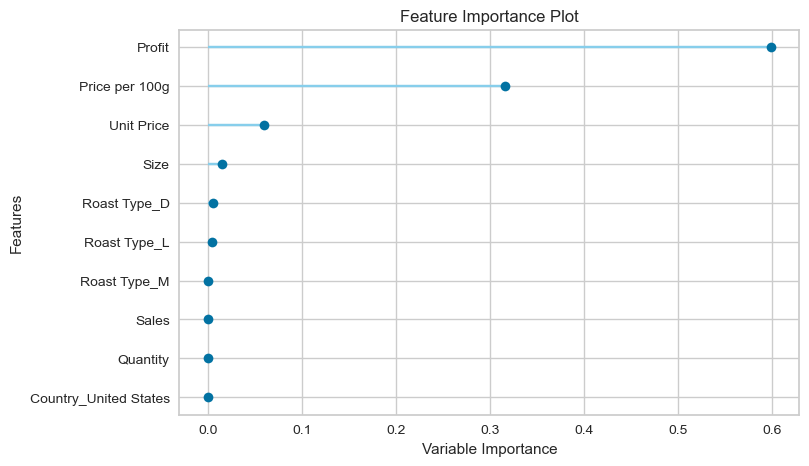

In [478]:
plot_model(tuned_gbc, plot='feature')

Najistotniejsze cechy wpływające na przewidywanie typu kawy to *Profit*, *Price per 100g*, *Unit Price* oraz *Size*.

### Confusion Matrix (Macierz pomyłek)

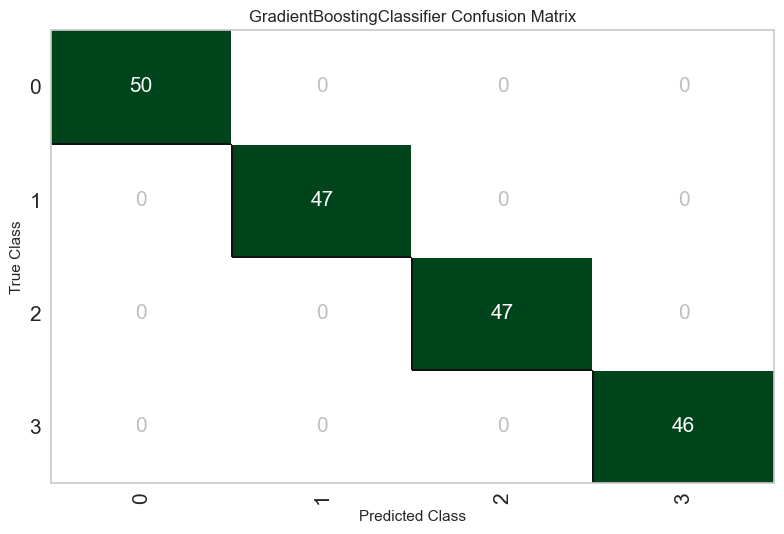

In [479]:
plot_model(gbc_model, plot = 'confusion_matrix')

Na podstawie macierzy pomyłek (confusion matrix) widać, że wszystkie typy kawy zostały poprawnie przyporządkowane, co świadczy o wysokiej dokładności modelu w przewidywaniu.

In [480]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Testowanie na danych ukrytych

In [481]:
unseen_predictions = predict_model(tuned_gbc, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Quantity,Size,Unit Price,Sales,Loyalty Card,Price per 100g,Profit,Country_Ireland,Country_United Kingdom,Country_United States,...,Day of Week_Friday,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Coffee Type,prediction_label,prediction_score
0,4,0.2,3.585,14.340,1,1.7925,0.21510,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,3,0.9992
1,6,0.2,3.585,21.510,0,1.7925,0.21510,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,0.9992
2,2,1.0,11.250,22.500,1,1.1250,1.01250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.9979
3,1,0.2,3.885,3.885,1,1.9425,0.34965,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9967
4,1,2.5,27.945,27.945,1,1.1178,3.07395,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9985


### Extra Trees Classifier

Wypróbujemy jeszcze inny model

In [482]:
et_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.9998,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9868,0.9998,0.9868,0.9875,0.9869,0.9824,0.9827
2,0.9868,1.0000,0.9868,0.9875,0.9868,0.9824,0.9827
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9868,1.0000,0.9868,0.9875,0.9868,0.9824,0.9827
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9868,1.0000,0.9868,0.9875,0.9869,0.9825,0.9827
8,0.9868,0.9994,0.9868,0.9875,0.9869,0.9825,0.9827


In [483]:
tuned_et = tune_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Wartości się poprawiły.

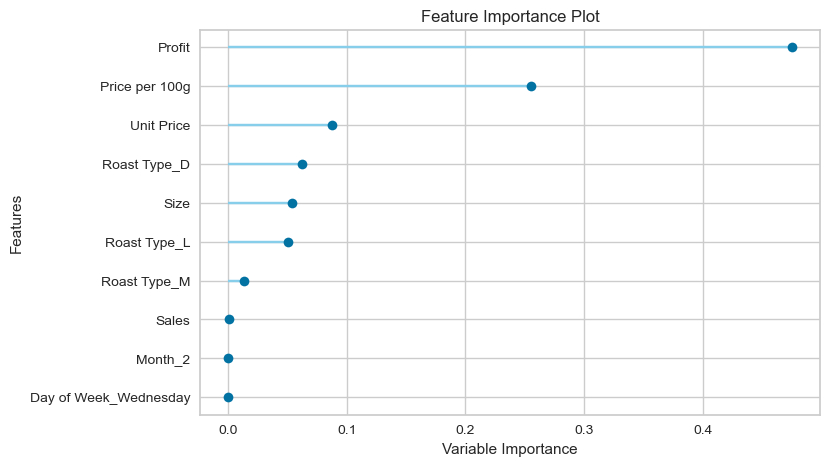

In [484]:
plot_model(tuned_et, plot='feature')

Możemy zauważyć, że w tym przypadku więcej cech miało wpływ na podjęcie decyzji o rodzaju kawy. Stopień wypalenia ma tutaj większe znaczenie niż poprzednio.

### **Usuwanie kolumn o małej wariancji**

In [485]:
# Wariancja dla kolumn numerycznych
numeric_columns = df_transformed.select_dtypes(include=['float64', 'int64', 'int32'])
variances = numeric_columns.var() 

# Usunięcie kolumn o bardzo małej wariancji (próg: 0.01)
low_variance_columns = variances[variances < 0.01].index 
merged_data_cleaned = df_transformed.drop(columns=low_variance_columns)
print("Kolumny o małej wariancji: ", low_variance_columns)

Kolumny o małej wariancji:  Index([], dtype='object')


Żadna z kolumn nie charakteryzuje się małą wariancją, co zapewnia, że nie ma potrzeby eliminowania żadnej cechy ze względu na to kryterium.

### **Wyznaczenie korelacji i usunięcie cech o wysokiej korelacji**

Macierz korelacji:

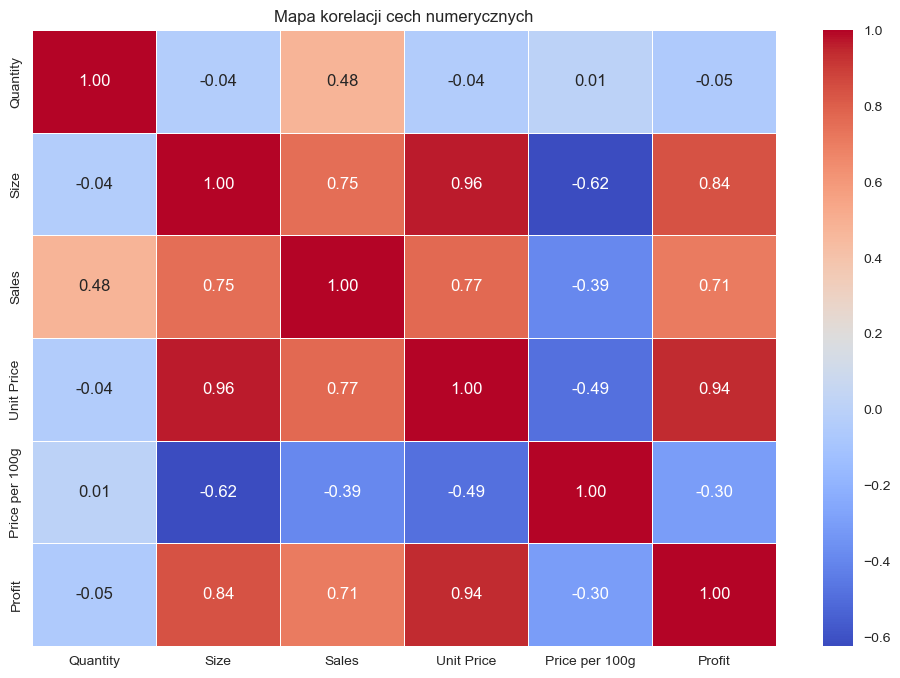

In [486]:
data=df_transformed
numerical_columns = ["Quantity", "Size", "Sales", "Unit Price", "Price per 100g", "Profit"]
correlation_matrix = data[numerical_columns].corr()
#print(correlation_matrix)


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa korelacji cech numerycznych")
plt.show()

**Usunięcie kolumn wysoko skorelowanych:**

Za wysoką korelację uznajemy te które przekraczają próg wartości 0.9

In [487]:
threshold = 0.9
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

high_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

data_cleaned = data.drop(columns=high_correlation)

print(f"Usunięte kolumny o wysokiej korelacji: {high_correlation}")
print(f"Nowy rozmiar danych: {data_cleaned.shape}")

Usunięte kolumny o wysokiej korelacji: ['Unit Price', 'Profit']
Nowy rozmiar danych: (1000, 31)


# **Outliery**

In [488]:
 # Funkcje do detekcji outlierów
def __get_mask_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr_c = (q3 - q1) * 1.5
    lower = q1 - iqr_c
    upper = q3 + iqr_c
    return (data < lower) | (data > upper)
 
def __get_mask_dev(data):
    return np.abs((data - data.mean()) / (data.std() + np.spacing(data.std()))) > 3
 
def get_detection_method(name):
    if name == 'iqr':
        return __get_mask_iqr
    elif name == 'dev':
        return __get_mask_dev
    else:
        raise Exception('Unknown detection method')
 
def get_outliers(df, detection_method, columns=None):
    if columns is None:
        columns = df.columns
    res = []
    for col in columns:
        res.append(detection_method(df[col]))
    return np.array(res).T
 
df = data_cleaned

### Wybór metody detekcji outlierów: 'iqr' lub 'dev'

 - iqr: Wykrywa wartości odstające za pomocą kwartyli Q1 i Q3 – jest bardziej odporny na skrajności w danych. Przydatne dla danych, które nie mają jednorodnego rozkładu.

 - dev: Wykrywa wartości odstające za pomocą odchylenia standardowego – jest czuły na wszystkie odstające wartości, zarówno te większe, jak i te mniejsze względem średniej.


In [489]:
method = 'iqr'  

selected_columns = ["Quantity", "Size", "Sales", "Price per 100g"]

detection_method = get_detection_method(method)
outliers_mask = get_outliers(df[selected_columns], detection_method)
final_mask = outliers_mask.any(axis=1)
 

no_outliers = df[~final_mask]
no_outliers.shape


(728, 31)

Po usunięciu Outlierów nasza ramka danych zminiła swój rozmiar z 1000 na 728 obserwacji.

## **Detekcja anomalii**

Przeprowadzimy detekcję anomalii przy użyciu modelu Isolation Forest. 

In [490]:
from pycaret.anomaly import *

In [491]:
exp_ano101 = setup(data_cleaned,
                  ignore_features = ['Customer Name', 'Address Line 1', 'City', 'Postcode'],
                   session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(1000, 31)"
2,Transformed data shape,"(1000, 31)"
3,Ignore features,4
4,Numeric features,31
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,CPU Jobs,-1


In [492]:
iforest = create_model('iforest') 
iforest_results = assign_model(iforest)
iforest_results.head()


,Quantity,Size,Sales,Loyalty Card,Price per 100g,Country_Ireland,Country_United Kingdom,Country_United States,Roast Type_D,Roast Type_L,...,Day of Week_Friday,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Coffee Type,Anomaly,Anomaly_Score
0,2,1.0,19.900000,1,0.9950,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,0,-0.041568
1,5,0.5,41.250000,1,1.6500,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,-0.062644
2,1,1.0,12.950000,1,1.2950,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,-0.038525
3,2,1.0,27.500000,0,1.3750,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,-0.017722
4,2,2.5,54.970001,0,1.0994,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,0,-0.016227


Wizualizacja wyników detekcji anomalii modelu *iforest*:

In [493]:
plot_model(iforest)

In [494]:
iforest_results['Anomaly'].value_counts()

Anomaly
0    950
1     50
Name: count, dtype: int64

Model 50 anomalii w zbiorze danych. Te anomalie mogą wskazywać na nietypowe zamówienia, błędne dane lub inne nietypowe zdarzenia.

In [495]:
df_no_outliers = iforest_results[iforest_results["Anomaly"] != 1]
df_no_outliers = df_no_outliers.reset_index().drop(columns=["index"])
df_no_outliers.shape

(950, 33)

Zapisanie danych do pliku csv

In [496]:
df_no_outliers.to_csv('df_no_outliers2.csv')

Do dalszej analizy będziemy korzystać z danych bez outlierów.

In [497]:
df_no_outliers2 = df_no_outliers.drop(columns = ["Anomaly", "Anomaly_Score"])

# **Uczenie modeli**

## **Skalowanie danych**

In [498]:
selected_columns = ['Quantity', 'Size', 'Sales', 'Price per 100g']

df_transformed = df_no_outliers2

# Skalowanie kolumn numerycznych
scaler = StandardScaler()
df_transformed[selected_columns] = scaler.fit_transform(df_transformed[selected_columns])
df_transformed['Loyalty Card'] = df_no_outliers2['Loyalty Card']  # Nie chcemy skalować Loyalty Card

df_transformed.head()




,Quantity,Size,Sales,Loyalty Card,Price per 100g,Country_Ireland,Country_United Kingdom,Country_United States,Roast Type_D,Roast Type_L,...,Month_11,Month_12,Day of Week_Friday,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Coffee Type
0,-0.920578,-0.002562,-0.580489,1,-1.245842,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
1,0.870308,-0.582127,-0.060833,1,0.576505,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,-1.517540,-0.002562,-0.749651,1,-0.411180,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-0.920578,-0.002562,-0.395506,0,-0.188603,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,-0.920578,1.736132,0.273110,0,-0.955379,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3


In [499]:
# Oddzielenie danych od targetu
X = df_transformed.drop(columns=['Coffee Type'])
y = df_transformed['Coffee Type']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model- 1. Gradient Boosting Classifier (GB)
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

# Model- 2. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Model - 3. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Model - 4. Extra Trees Classifier
et_model = ExtraTreesClassifier(random_state=42)
et_model.fit(X_train, y_train)
et_preds = et_model.predict(X_test)



gb_acc = accuracy_score(y_test, gb_preds)
gb_report = classification_report(y_test, gb_preds)

dt_acc = accuracy_score(y_test, dt_preds)
dt_report = classification_report(y_test, dt_preds)

rf_acc = accuracy_score(y_test, rf_preds)
rf_report = classification_report(y_test, rf_preds)

et_acc = accuracy_score(y_test, et_preds)
et_report = classification_report(y_test, et_preds)


In [500]:
print("Gradient Boosting Model Accuracy:", gb_acc)
print("Gradient Boosting Classification Report:\n", gb_report)

Gradient Boosting Model Accuracy: 1.0
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        51
           3       1.00      1.00      1.00        45

    accuracy                           1.00       190
   macro avg       1.00      1.00      1.00       190
weighted avg       1.00      1.00      1.00       190



In [501]:
print("Decision Tree Model Accuracy:", dt_acc)
print("Decision Tree Classification Report:\n", dt_report)

Decision Tree Model Accuracy: 0.9578947368421052
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        41
           1       0.96      0.94      0.95        53
           2       0.91      0.94      0.92        51
           3       1.00      1.00      1.00        45

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190



In [502]:
print("Random Forest Model Accuracy:", rf_acc)
print("Random Forest Classification Report:\n", rf_report)


Random Forest Model Accuracy: 0.8
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        41
           1       0.75      0.68      0.71        53
           2       0.80      0.80      0.80        51
           3       0.87      0.91      0.89        45

    accuracy                           0.80       190
   macro avg       0.80      0.81      0.80       190
weighted avg       0.80      0.80      0.80       190



In [503]:
print("Extra Trees Model Accuracy:", et_acc)
print("Extra Trees Classification Report:\n", et_report)

Extra Trees Model Accuracy: 0.7105263157894737
Extra Trees Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.78      0.67        41
           1       0.71      0.57      0.63        53
           2       0.78      0.76      0.77        51
           3       0.79      0.76      0.77        45

    accuracy                           0.71       190
   macro avg       0.72      0.72      0.71       190
weighted avg       0.72      0.71      0.71       190



 - Gradient Boosting Classifier osiągnął najwyższą dokładność (1.0) oraz idealne wyniki w f1-score dla wszystkich klas, co oznacza, że model doskonale radzi sobie z klasyfikacją różnych typów kawy.

 - Decision Tree Classifier również dobrze radzi sobie z przewidywaniem typów kawy, osiągając dokładność na poziomie 95.79%, ale ma nieco niższą precyzję dla klasy 2 w porównaniu do GB.

 - Random Forest Classifier uzyskał dokładność 80%, z dobrym wynikiem dla klasy 3, ale niższą precyzję dla klas 0 i 1.

 - Extra Trees Classifier osiągnął dokładność 71.05%, z problemami głównie w predykcji klasy 1 i klasy 0.

# **PCA** i **ICA**

Redukcja wymiarów w zbiorze danych metodą PCA oraz ICA.

### **PCA na początkowym zbiorze**

Przeprowadzamy analizę głównych składowych (PCA), obliczając proporcje wariancji wyjaśnianej przez każdą z głównych składowych. 

Dzięki funkcji explained_variance_ratio_ widzimy, ile wariancji zostało wyjaśnione przez poszczególne komponenty. 

Kod identyfikuje komponenty, które wyjaśniają mniej niż 1% wariancji (dzięki variances<0.01), co może pomóc w zrozumieniu, które cechy nie mają istotnego wpływu na dane.

In [504]:
pca = PCA()

pca.fit(X1)

variances = pca.explained_variance_ratio_ #konwencje _prywatne
print(f"Variances: {variances}")

#sprawdzamy ile wariancji jest mniejszych niż 1%
zeros = (variances<0.01).sum()
print(f"Liczba wariancji mniejszych niż 0.01: {zeros}")

Variances: [9.7643e-01 2.1259e-02 5.3607e-04 2.0429e-04 1.8216e-04 1.4712e-04
 1.3370e-04 1.1218e-04 8.0864e-05 7.7185e-05 7.6670e-05 7.4644e-05
 7.2687e-05 7.1995e-05 5.6222e-05 5.0923e-05 4.8393e-05 4.6764e-05
 4.5863e-05 4.4969e-05 4.3222e-05 4.1249e-05 3.8541e-05 3.7149e-05
 3.5732e-05 3.3298e-05 1.7887e-05 4.0893e-06 1.9257e-31 7.2138e-33
 7.2138e-33 7.2138e-33]
Liczba wariancji mniejszych niż 0.01: 30


In [505]:
np.set_printoptions(precision=4)

cumulated_variances = variances.cumsum()
print(f"Cumulated variances: {cumulated_variances}")


Cumulated variances: [0.9764 0.9977 0.9982 0.9984 0.9986 0.9988 0.9989 0.999  0.9991 0.9992
 0.9992 0.9993 0.9994 0.9995 0.9995 0.9996 0.9996 0.9997 0.9997 0.9997
 0.9998 0.9998 0.9999 0.9999 0.9999 1.     1.     1.     1.     1.
 1.     1.    ]


Możemy zobaczyć, ile łącznie wariancji wyjaśnia każdy z komponentów. 

Na podstawie tych wyników łatwo zauważyć, że po pewnym progu dalsze komponenty nie mają już znaczącego wpływu na dane.

In [506]:
dim_099 = (cumulated_variances <= 0.99).sum() + 1
pca_099 = PCA(0.99)
pca_099.fit(X1)

print(f"Numer komponentów: {pca_099.n_components_}")

Numer komponentów: 2


Wymiar, po którym skumulowana wariancja wyjaśniana przez PCA przekracza 99% to 2.

In [507]:
x1_transformed_pca = pca_099.transform(X1)

print(f"Oryginalny rozmiar: {X1.shape}")
print(f"Rozmiar po transformacji PCA: {x1_transformed_pca.shape}")

Oryginalny rozmiar: (1000, 32)
Rozmiar po transformacji PCA: (1000, 2)


Zapis zbioru danych

In [508]:
df_pca = pd.DataFrame(x1_transformed_pca)
df_pca.to_csv('df_ics.csv', index=False)

### **PCA po redukcji wymiarów**

In [509]:
pca = PCA()

pca.fit(X)

variances = pca.explained_variance_ratio_
print(f"Variances: {variances}")

#sprawdzamy ile wariancji jest mniejszych niż 1%
zeros = (variances<0.01).sum()
print(f"Liczba wariancji mniejszych niż 0.01: {zeros}")

Variances: [3.1855e-01 1.7285e-01 8.7319e-02 4.8890e-02 3.7655e-02 3.4368e-02
 2.8843e-02 2.1650e-02 2.0640e-02 2.0507e-02 2.0203e-02 1.9914e-02
 1.9498e-02 1.5179e-02 1.3661e-02 1.2958e-02 1.2751e-02 1.2505e-02
 1.1781e-02 1.1384e-02 1.1360e-02 1.0374e-02 1.0186e-02 9.8415e-03
 9.5421e-03 7.5937e-03 1.8100e-14 5.0727e-16 5.0727e-16 3.8366e-16]
Liczba wariancji mniejszych niż 0.01: 7


Wyniki się zmieniły, teraz nie 30 a 7 komponentów posiada niską wariancję.

In [510]:
np.set_printoptions(precision=4)

cumulated_variances = variances.cumsum()
print(f"Cumulated variances: {cumulated_variances}")
    
#na końcu wymiary w których nic nie ma

Cumulated variances: [0.3185 0.4914 0.5787 0.6276 0.6653 0.6996 0.7285 0.7501 0.7708 0.7913
 0.8115 0.8314 0.8509 0.8661 0.8797 0.8927 0.9054 0.9179 0.9297 0.9411
 0.9525 0.9628 0.973  0.9829 0.9924 1.     1.     1.     1.     1.    ]


In [511]:
dim_099 = (cumulated_variances <= 0.99).sum() + 1
pca_099 = PCA(0.99)
pca_099.fit(X)

print(f"Number komponentów: {pca_099.n_components_}")

Number komponentów: 25


 Wynik mówi nam, że z 25 komponentów PCA możemy uzyskać 99% informacji. To pozwala na zmniejszenie wymiarowości zbioru danych, zachowując jednocześnie dużą część ważnych informacji.

In [512]:
x_transformed_pca = pca_099.transform(X)

print(f"Oryginalny rozmiar: {X.shape}")
print(f"Rozmiar po transformacji PCA: {x_transformed_pca.shape}")


Oryginalny rozmiar: (950, 30)
Rozmiar po transformacji PCA: (950, 25)


## **ICA**

In [513]:
ica_25 = FastICA(25) #liczba elementów (tylko)
ica_25.fit(X1)

x1_transformed_ica = ica_25.transform(X1)

print(f"Oryginalny rozmiar: {X.shape}")
print(f"Romiar po transformacji ICA: {x1_transformed_ica.shape}")


Oryginalny rozmiar: (950, 30)
Romiar po transformacji ICA: (1000, 25)


Zapis zbioru danych

In [514]:
df_ica = pd.DataFrame(x1_transformed_ica)
df_ica.to_csv('df_ics.csv', index=False)

In [515]:
y = merged_data["Coffee Type"]
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
# Skalowanie kolumn numerycznych
scaler = StandardScaler()
scaler.fit(X1_train)
X1_train_scaled = scaler.transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

dims = 30

pca = PCA(dims)
pca.fit(X1_train_scaled)

x_train_pca = pca.transform(X1_train_scaled)
x_test_pca = pca.transform(X1_test_scaled)

ica = FastICA(dims)
ica.fit(X1_train_scaled)

x_train_ica = ica.transform(X1_train_scaled)
x_test_ica = ica.transform(X1_test_scaled)

models = [GradientBoostingClassifier(random_state=42), DecisionTreeClassifier(random_state=42), 
          RandomForestClassifier(random_state=42), ExtraTreesClassifier(random_state=42)]
for model in models:
    print(f"MODEL: {model.__class__.__name__}")

    print("\tORG:")
    model.fit(X1_train, y_train)
    y_pred = model.predict(X1_test)
    print(f"\t\t{accuracy_score(y_test, y_pred)}")

    print("\tSCALED:")
    model.fit(X1_train_scaled, y_train)
    y_pred = model.predict(X1_test_scaled)
    print(f"\t\t{accuracy_score(y_test, y_pred)}")

    print("\tPCA:")
    model.fit(x_train_pca, y_train)
    y_pred = model.predict(x_test_pca)
    print(f"\t\t{accuracy_score(y_test, y_pred)}")

    print("\tICA:")
    model.fit(x_train_ica, y_train)
    y_pred = model.predict(x_test_ica)
    print(f"\t\t{accuracy_score(y_test, y_pred)}")

MODEL: GradientBoostingClassifier
	ORG:
		1.0
	SCALED:
		1.0
	PCA:
		0.84
	ICA:
		0.875
MODEL: DecisionTreeClassifier
	ORG:
		1.0
	SCALED:
		1.0
	PCA:
		0.795
	ICA:
		0.685
MODEL: RandomForestClassifier
	ORG:
		0.995
	SCALED:
		0.995
	PCA:
		0.805
	ICA:
		0.815
MODEL: ExtraTreesClassifier
	ORG:
		0.99
	SCALED:
		0.99
	PCA:
		0.755
	ICA:
		0.795


ICA wydaje się mieć lepszy wpływ na poprawę dokładności modelu niż PCA, szczególnie dla GradientBoosting i DecisionTree.

# **Wnioski i podsumowanie**

Gradient Boosting jest najlepszym modelem w kontekście przewidywania typu kawy, osiągając najwyższą dokładność i równowagę w predykcjach.


W ramach projektu przeprowadziłyśmy kompleksową analizę danych sprzedażowych i produktowych zawartych w zbiorze *CoffeeOrdersData*. Postawiłyśmy na zrozumienie dynamiki rynku kawowego oraz przewidywanie preferencji klientów co do typu kawy. Głównym celem projektu było stworzenie modeli predykcyjnych, które umożliwiłyby skuteczniejsze podejmowanie decyzji biznesowych związanych z ofertą produktową. 


W trakcie analizy pokazałyśmy, które cechy mają największy wpływ na decyzję klientów. 
Zastosowałyśmy modele klasyfikacyjne (Gradient Boosting, Decision Tree i Random Forest), które umożliwiły przewidywanie rodzaju kawy z wysoką dokładnością.
Porównałyśmy utworzone modele dzięki czemu dowiedziałyśmy się, że Gradient Boosting okazał się najskuteczniejszy.  

Użyłyśmy zaawansowanych metod analizy danych takie jak PCA, ICA (redukcja wymiarowości), która pozwoliła na uproszczenie struktury danych bez utraty kluczowych informacji.

Dzięki przeprowadzonej analizie zobaczyłyśmy zależności między ceną, typem kawy i rodzajem palenia. Wyniki projektu mogą być wykorzystane w przyszłości w praktyce, ponieważ wnioski wyciągnięte z modeli predykcyjnych mogą posłużyć jako fundament dla dalszych badań oraz inicjatyw mających na celu rozwój oferty kawowej w dynamicznie zmieniającym się otoczeniu rynkowym.